# 伪迹注释

## 引言

我们将在这里展示如何识别伪迹，然后进行注释。注释将在FIF数据文件中表示。在这个阶段，切片或试验不会被拒绝；相反，注释可能会在以后使用。例如，它们可以用来拒绝眨眼或肌肉收缩的试验，这取决于它们与分析的相关性。  

## Preparation

Import the relevant modules: 

In [1]:
import os.path as op
import os
import sys
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import annotate_muscle_zscore
import matplotlib.pyplot as plt


### File overview
The chapter relies on the input files (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
~~~
and generates the output files:
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif

<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.csv
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.csv
~~~

Set the path and load the FIF-files: 

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '02'
meg_suffix = 'meg'
max_suffix = 'raw_sss'
ann_suffix = 'ann'

deriv_root = '/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing'

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=max_suffix, 
            root=deriv_root, extension='.fif', check=False)


# The annotations will be stored in these files
deriv_fname_fif = bids_path.basename.replace(max_suffix, ann_suffix) # fif output filename

deriv_fname_fif_1 = op.join(bids_path.directory, deriv_fname_fif)
deriv_fname_fif_2 = deriv_fname_fif_1.replace('run-01', 'run-02')

deriv_fname_csv_1 = deriv_fname_fif_1.replace('fif', 'csv') # csv output filename
deriv_fname_csv_2 = deriv_fname_csv_1.replace('run-01', 'run-02') 


print(bids_path)
print(deriv_fname_fif_1)
print(deriv_fname_csv_1)

/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.csv


In [3]:
raw1 = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


/tmp/ipykernel_736056/1752485552.py:1: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw1 = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_736056/1752485552.py:1: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw1 = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_736056/1752485552.py:1: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*meg.json"
  raw1 = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_736056/1752485552.py:1: RuntimeWarning: participants.tsv file not found for /home/ubuntu

## 识别眼睛眨眼

在这里，我们展示了如何根据垂直EOG通道（在我们的例子中为EOG001）自动标记与眨眼相关的伪影。在带通滤波1-10 Hz之间的EOG信号后，眨眼检测的阈值根据：

$$ (max(vEOG) - min(vEOG)) / 4 $$

从超过阈值之前的250毫秒开始的500毫秒长的段被注释为眨眼。 

In [4]:
eog_events = mne.preprocessing.find_eog_events(raw1, ch_name='EOG001') 

Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG001 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 487 significant peaks
Number of EOG events detected: 487


总共有487个事件被识别为眨眼。为了在数据集上写入这些事件，我们需要创建一个Annoation对象，其中包含每次眨眼的开始、持续时间和事件类型的描述（即标签）：

In [5]:
n_blinks = len(eog_events)
onset = eog_events[:, 0] / raw1.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
description = ['blink'] * n_blinks
orig_time = raw1.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)

## 寻找肌肉伪影

肌肉伪影是从110-140 Hz范围内过滤的磁力计数据中识别出来的。数据随后被z评分。如果它们超过值*threshold_muscle*，相应的数据部分将被注释为肌肉伪影。未注释数据的最短允许持续时间为0.2秒；较短的片段将被合并到周围的注释中。

In [6]:
threshold_muscle = 10  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw1, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



为了检查用于肌肉注释的阈值是否适合当前数据，我们在记录中绘制z分数。阈值由红线表示。

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity (threshold = 10)')]

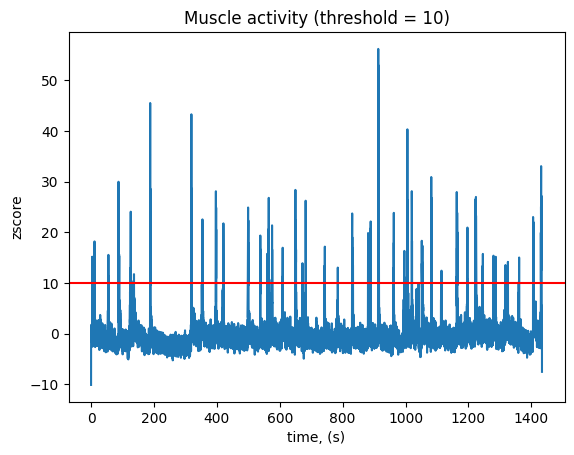

In [7]:
%matplotlib inline
fig1, ax = plt.subplots()
ax.plot(raw1.times, scores_muscle);
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity (threshold = %s)' % threshold_muscle)

从这张图中，我们可以看到阈值高于基线水平。尽管如此，它还是捕获了代表肌肉伪影的高伽马活动中的所有选择。 

## 在数据集中包含注释并检查

现在标记数据集中的所有注释。


*调用set_annotations（）替换当前存储在Raw对象中的任何注释。为了防止这种情况，我们首先提取它们的注释，然后将它们与blink和肌肉注释组合在一起*。

In [8]:
annotations_event = raw1.annotations 
raw1.set_annotations(annotations_event + annotations_blink + annotations_muscle)

<Raw | sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif, 343 x 1434000 (1434.0 s), ~3.67 GiB, data loaded>

要检查注释，请编写：

Using matplotlib as 2D backend.


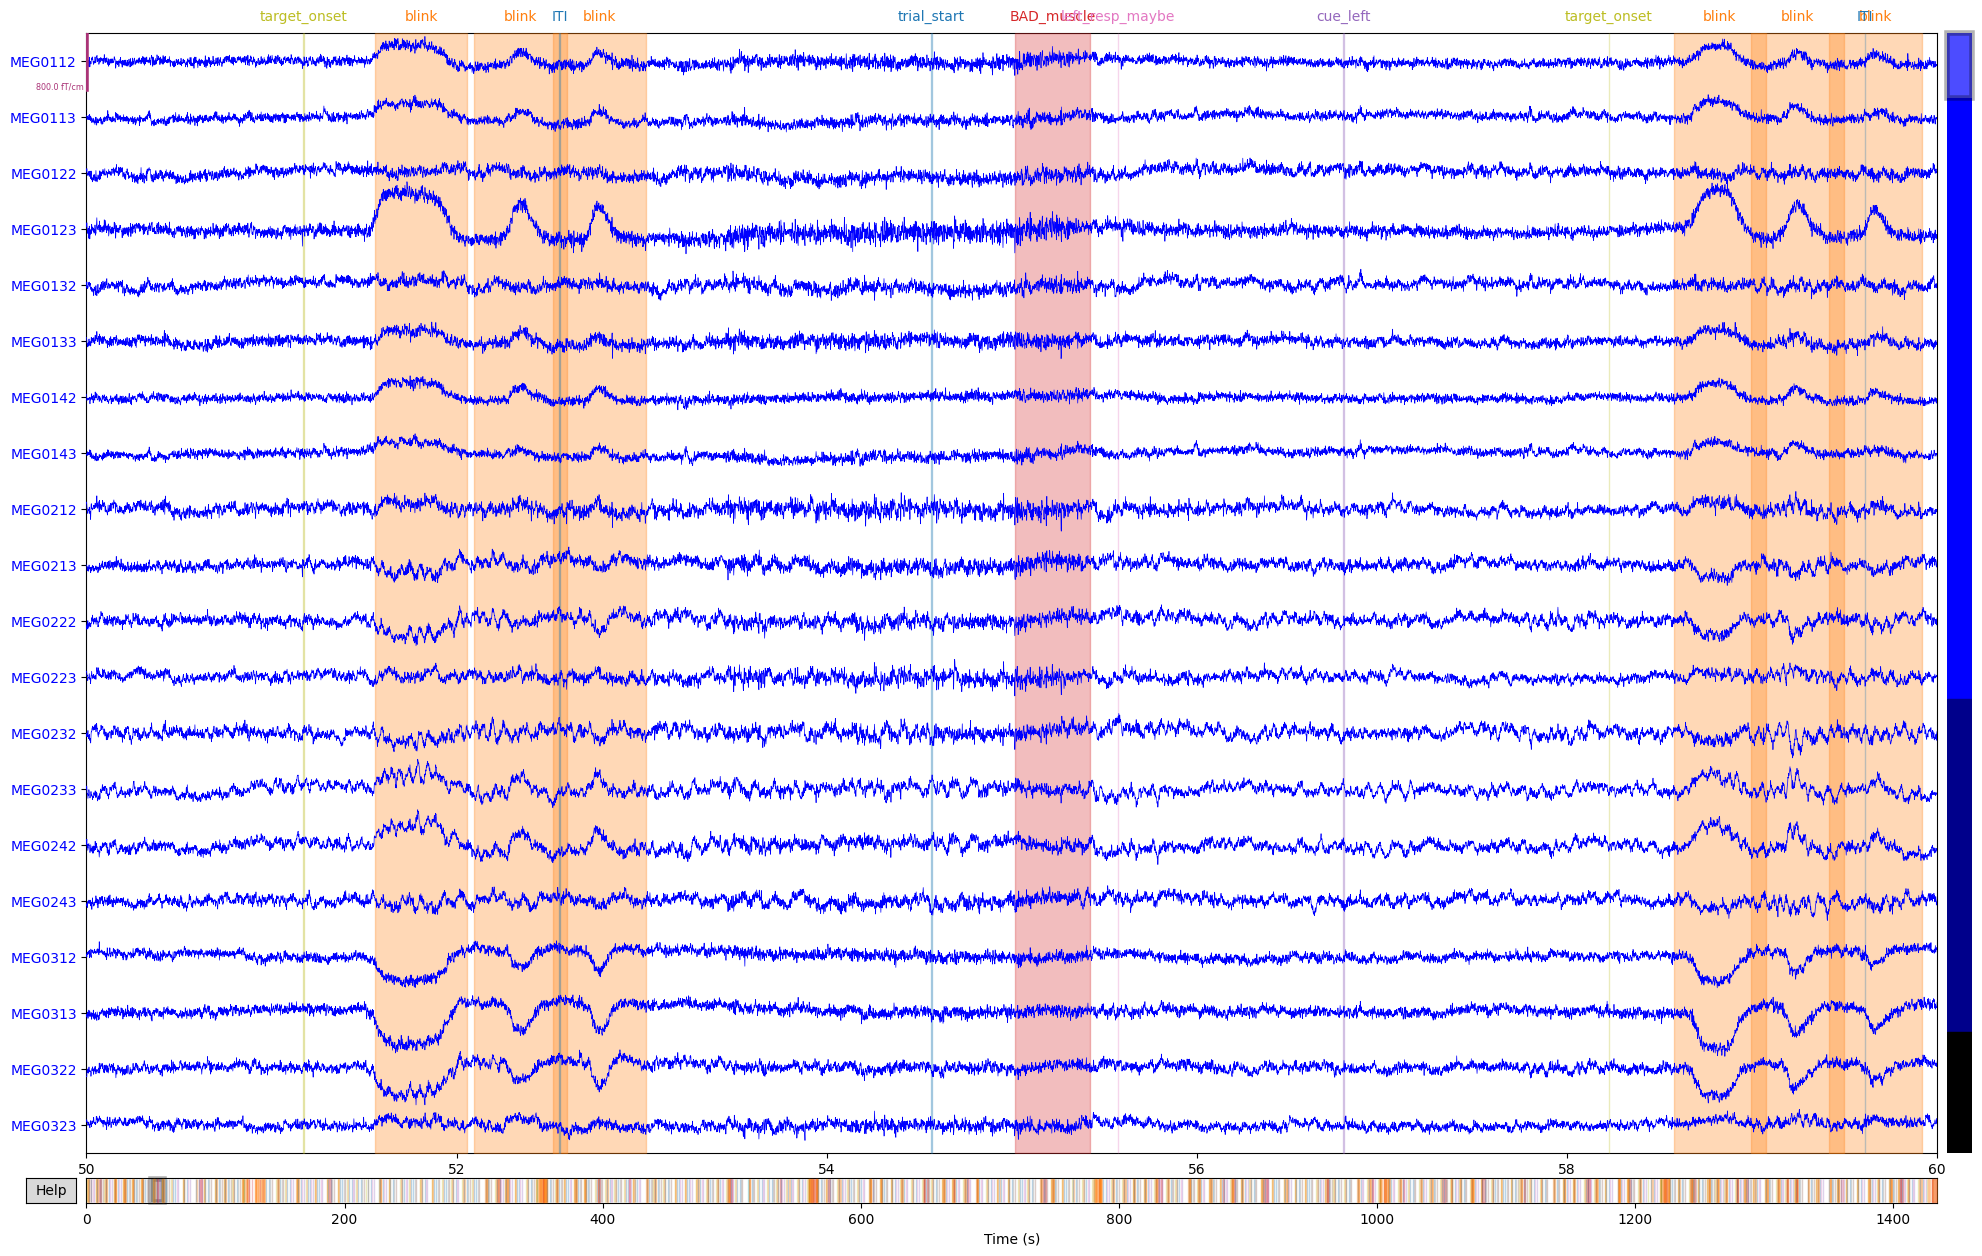

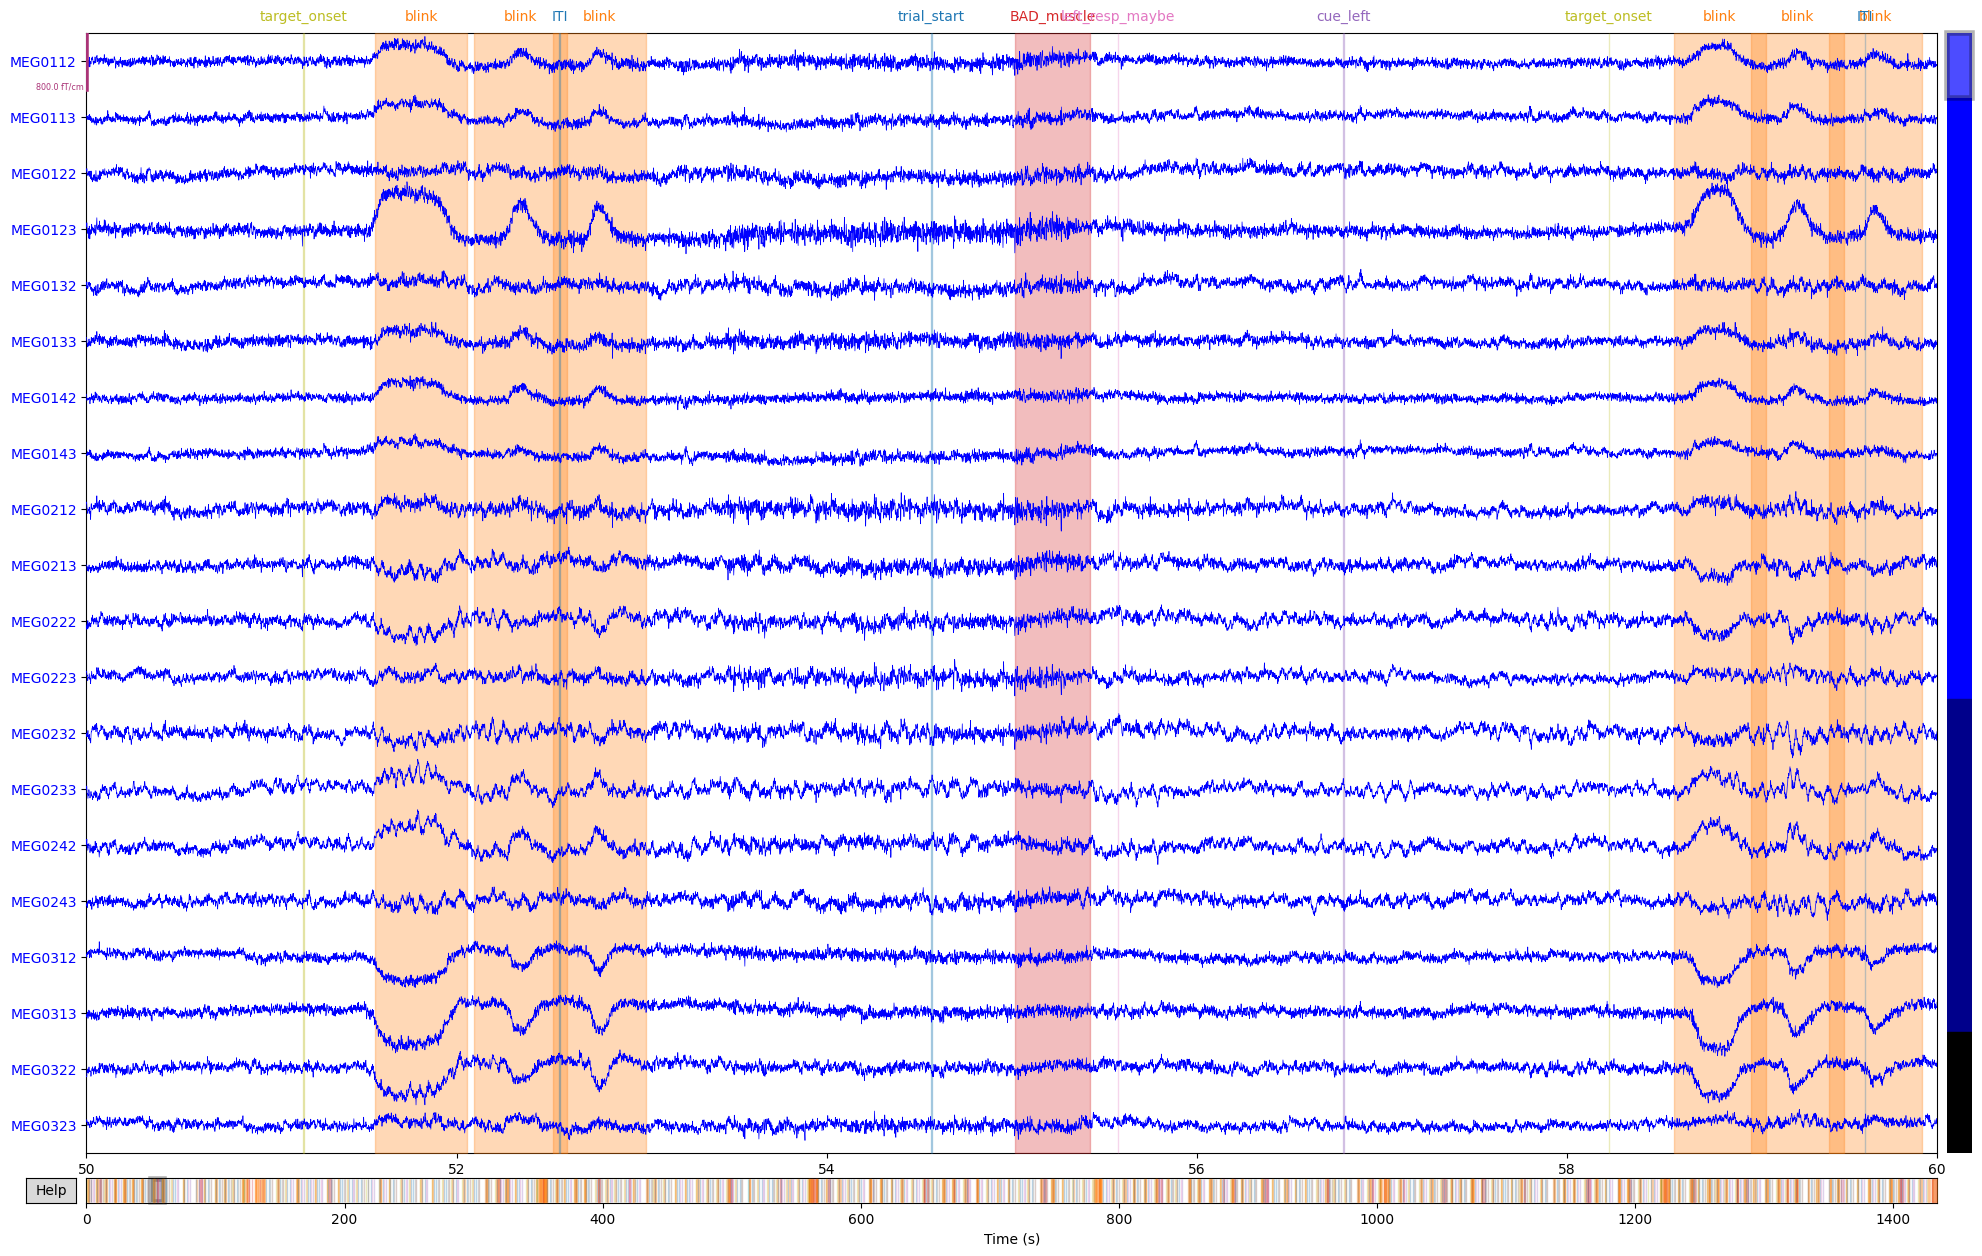

In [9]:
%matplotlib inline
raw1.plot(start=50)

为了专门检查眼部伪影，显示EOG传感器： 

/tmp/ipykernel_736056/255727686.py:2: RuntimeWarning: The unit for channel(s) EOG001 has changed from NA to V.
  raw1.set_channel_types({'EOG001': 'eog'})
/tmp/ipykernel_736056/255727686.py:3: RuntimeWarning: The unit for channel(s) EOG002 has changed from NA to V.
  raw1.set_channel_types({'EOG002': 'eog'})


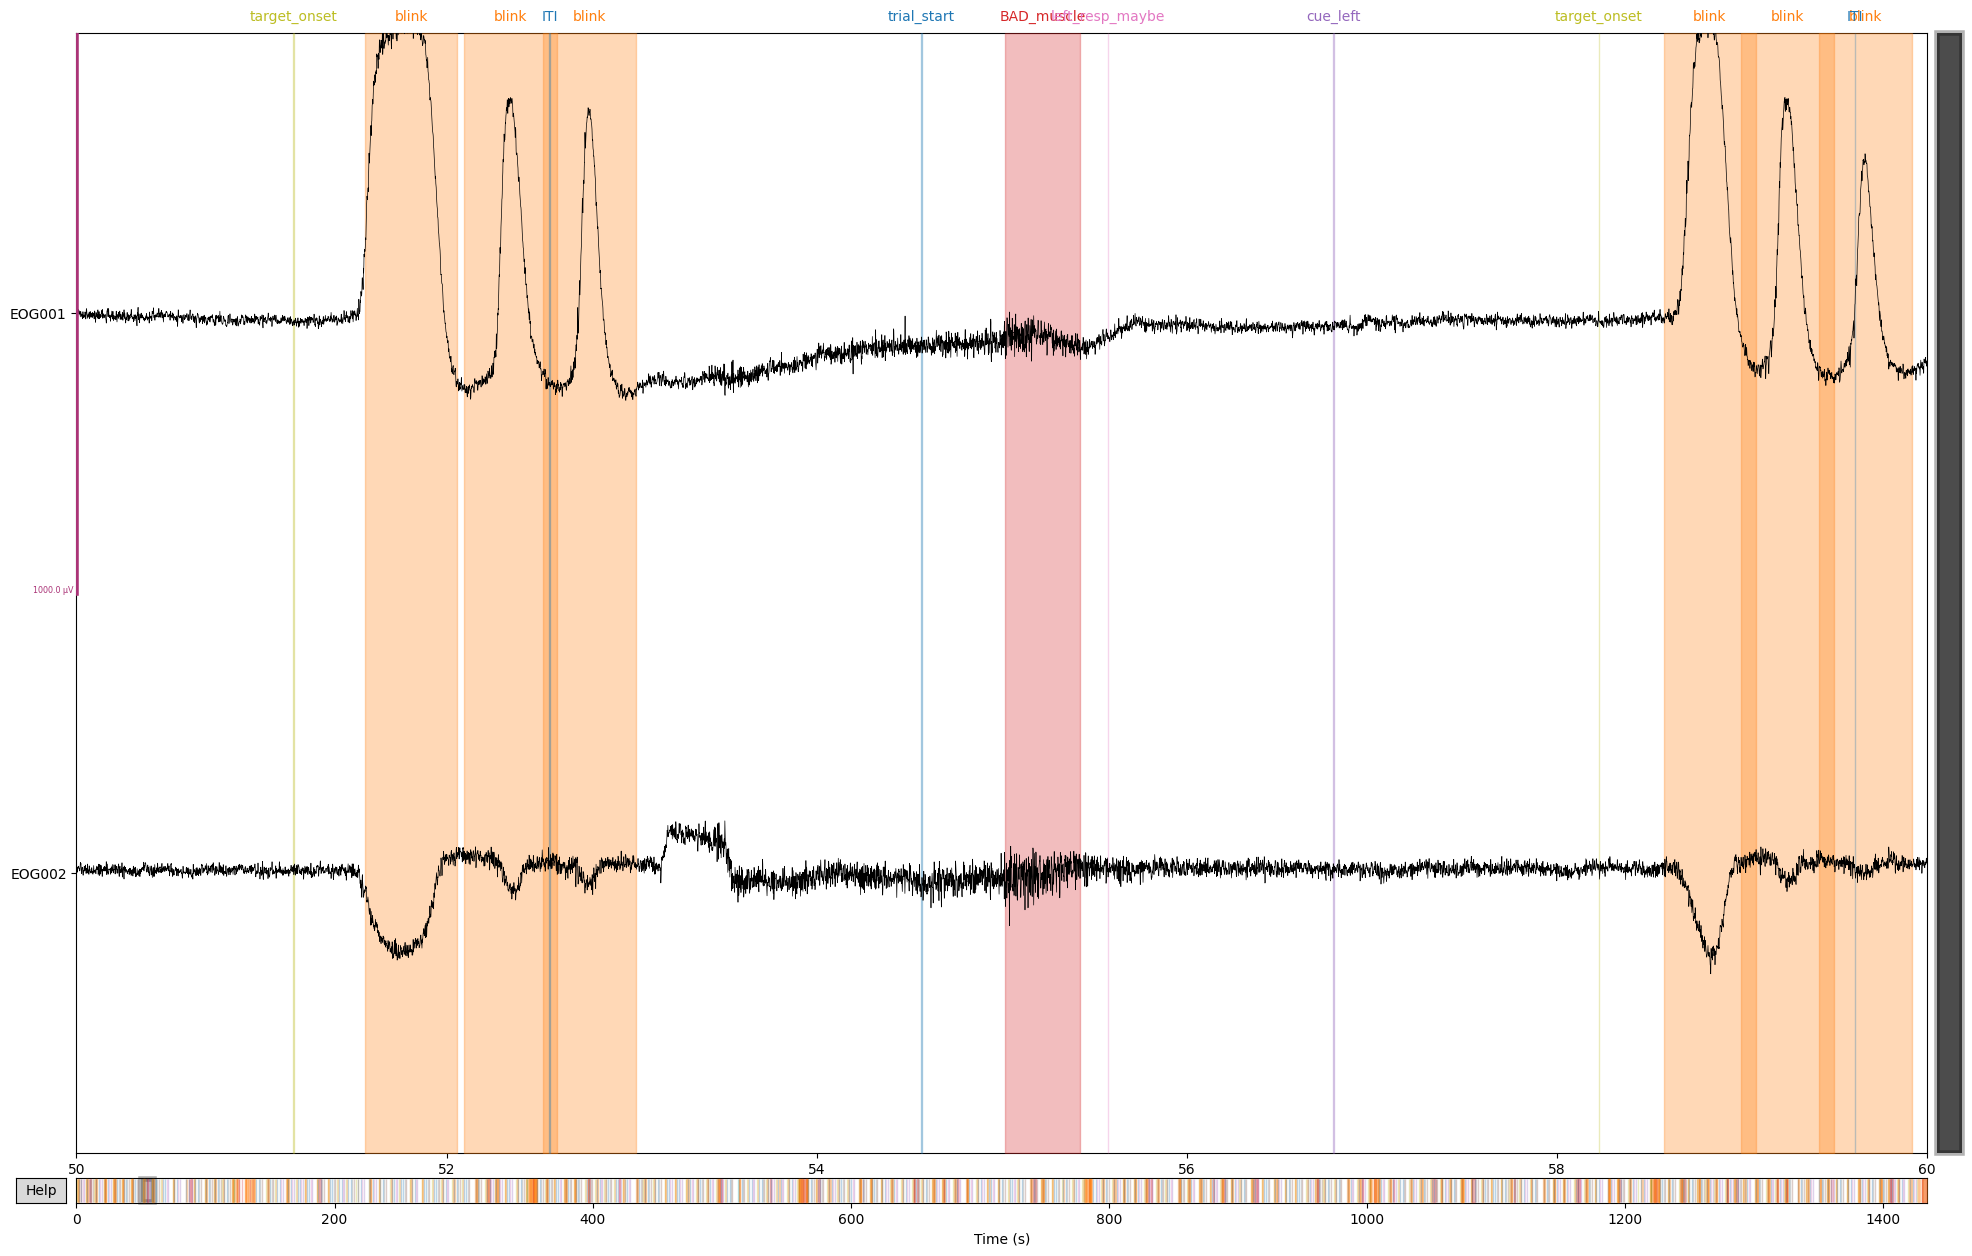

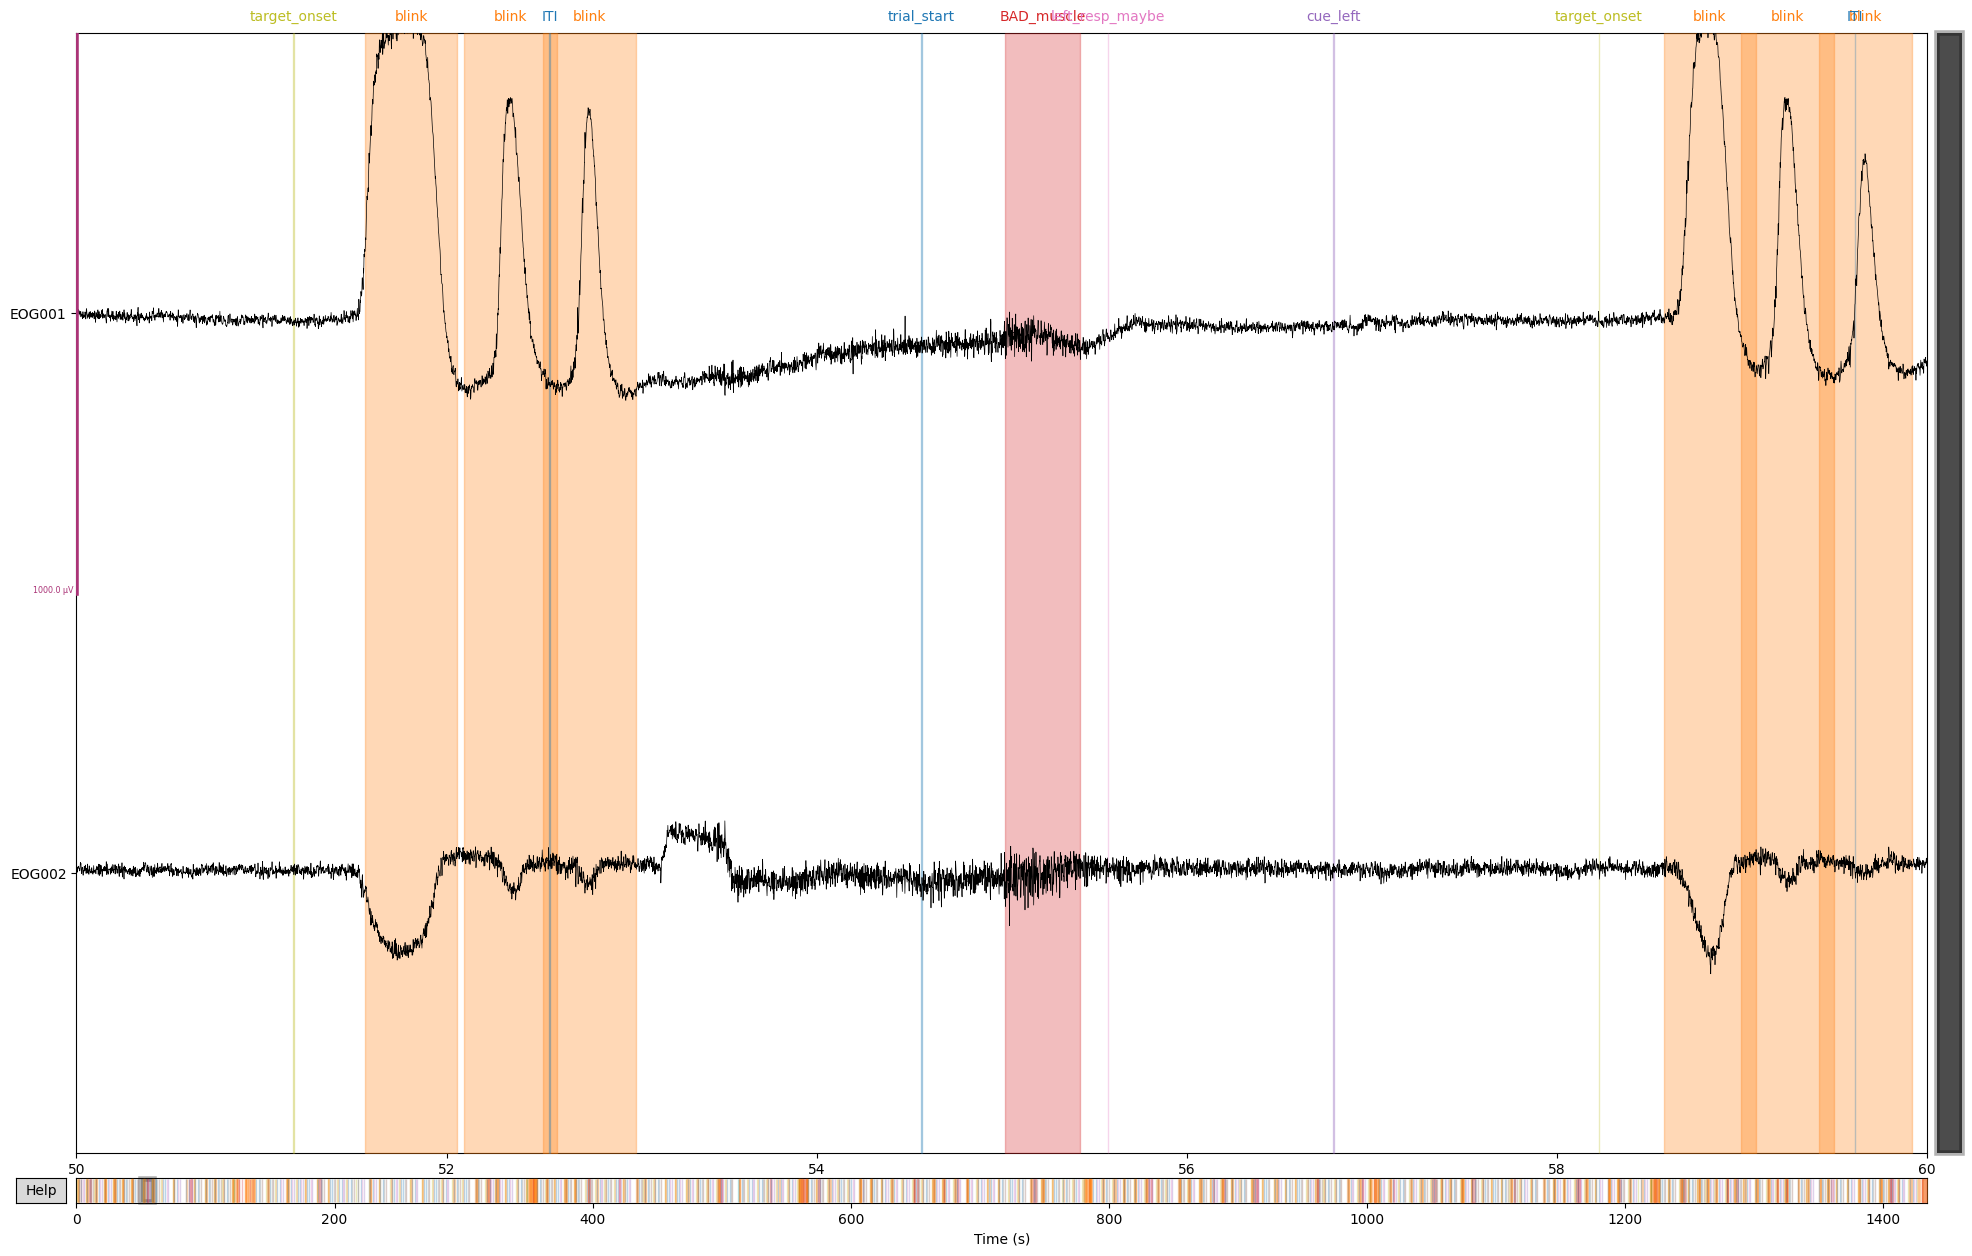

In [10]:
# Set the channel type as 'eog'
raw1.set_channel_types({'EOG001': 'eog'})
raw1.set_channel_types({'EOG002': 'eog'})

eog_picks = mne.pick_types(raw1.info, meg=False, eog=True)

scl = dict(eog=500e-6)
raw1.plot(order=eog_picks, scalings=scl, start=50)

MEGIN系统中传感器的布局将用于回答以下问题（改编自胡等人，2018年）。


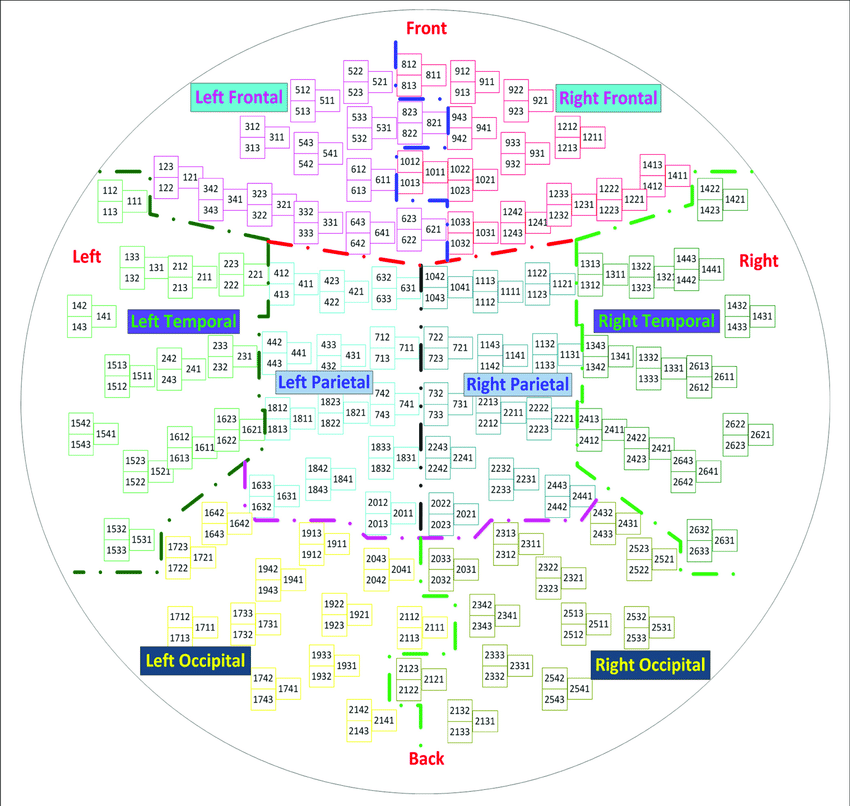


**问题1：** 在哪些传感器中肌动伪迹特别强大？解释原因。

**问题2：** 在哪些传感器中眼动伪迹特别强大？解释原因。

**问题3：** 是hEOG还是vEOG最适合识别扫视？解释原因。 


## 保存伪迹注释

将注释保存在文件中以供后续部分使用：

In [11]:
raw1.save(deriv_fname_fif_1, overwrite=True)
raw1.annotations.save(deriv_fname_csv_1, overwrite=True)

Writing /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif


/tmp/ipykernel_736056/3888226814.py:1: RuntimeWarning: This filename (/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw1.save(deriv_fname_fif_1, overwrite=True)


Closing /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
[done]


## 对数据集的其余部分执行伪迹注释 

现在对第二个FIF文件执行注释操作：

In [12]:
bids_path.update(run='02')
print(bids_path.basename)

raw2 = read_raw_bids(bids_path=bids_path, 
                      extra_params={'preload':True},
                      verbose=True) 

# Blinks
eog_events = mne.preprocessing.find_eog_events(raw2, ch_name='EOG001') 
n_blinks = len(eog_events)  
onset = eog_events[:, 0] / raw2.info['sfreq'] - 0.25
onset -= raw2._first_time  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks  
orig_time = raw2.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)

# Muscle
threshold_muscle = 10
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw2, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

# Annotate the data files
raw2.set_annotations(raw2.annotations + annotations_blink + annotations_muscle)

# Save 
raw2.save(deriv_fname_fif_2, overwrite=True)
raw2.annotations.save(deriv_fname_csv_2, overwrite=True)

sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
Opening raw data file /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades


/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:4: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw2 = read_raw_bids(bids_path=bids_path,
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:4: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw2 = read_raw_bids(bids_path=bids_path,
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:4: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preproc

Selecting channel EOG001 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 487 significant peaks
Number of EOG events detected: 487
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.9s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)

Overwriting existing file.
Writing /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif


/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:25: RuntimeWarning: Omitted 487 annotation(s) that were outside data range.
  raw2.set_annotations(raw2.annotations + annotations_blink + annotations_muscle)
/var/folders/hd/b_5m7wh54rv2hb3s09qyc3r40000gs/T/ipykernel_60620/4072543864.py:28: RuntimeWarning: This filename (/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw2.save(deriv_fname_fif_2, overwrite=True)


Closing /Volumes/jenseno-avtemporal-attention/Projects/FLUX/data/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
[done]
Overwriting existing file.


## Pregistration and publication

Preregistration: Report the the type of artifacts being annotated as well as the threshold selections. 


Publication, example:

"Artefacts were annotated in the raw data such that they later could be used to reject trials if relevant. Ocular artefacts were identified in the vertical EOG data (bandpass filtered at 1 - 10 Hz) according to segments exceeding a threshold defined according to (max(EOG) - min(EOG))/4. Ocular artefacts were considered 500 ms long centred around the time they exceeded the threshold. Muscle artefacts were identified in magnetometers data bandpass filtered at 110 - 140 Hz. The filtered data were z-scored and segments exceeding a z-score of 10 were annotated as muscle artefacts. " 

## References 

Muthukumaraswamy, S. (2013). High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations. Frontiers in Human Neuroscience, 7:138

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616

